##Prediction Model
###Premier League 2010_2011  to 2024-2025 season


Overview of the datasets :
We've successfully loaded the dataset for the 2010-2011 to 2024-2025 Premier League season. As we can see, it contains a wealth of information about each match. Let's break down the most important columns for our project:

HomeTeam and AwayTeam: The names of the two teams that played.

FTHG and FTAG: The Full Time Home Goals and Full Time Away Goals. These columns tell us the final score of the match.

FTR: The Full Time Result. This is our target variable. This is what we want to predict. It has three possible values:

'H' for a home win

'A' for an away win

'D' for a draw

Match Statistics: We also have a lot of statistics for each match, like:

HS and AS: Home and Away team shots

HST and AST: Home and Away team shots on target

HC and AC: Home and Away team corners

HF and AF: Home and Away team fouls committed

HY, AY, HR, AR: Yellow and Red cards for home and away teams.

Betting Odds: There are also many columns with betting odds from different bookmakers (B365, BW, IW, etc.). These can be very powerful features because they represent the market's prediction of the match outcome.


###


1.   Load and combine the 15 season's dataset
2.   Feature Engineer by adding the new IsPromoted feature by comparing the list of teams from one season to another.
3.   Calculate the team form features as we done for 2010 season.



##Complete Code




In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

# --- 1. Load and Combine All Available Seasons ---
all_dfs = []
years = range(2010, 2025) # For seasons 2010-11 to 2024-25
for year in years:
    filename = f"/content/PlModelPredictor/data/E{year}.csv"
    try:
        df = pd.read_csv(filename, encoding='latin1', on_bad_lines='skip')
        all_dfs.append(df)
        print(f"Successfully loaded {filename}")
    except FileNotFoundError:
        print(f"Warning: Could not find {filename}. Skipping.")

if not all_dfs:
    print("No data files were loaded. Exiting.")
else:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(f"\nSuccessfully combined {len(all_dfs)} files. Total matches: {len(combined_df)}")

    # --- 2. Data Cleaning and Initial Preparation ---
    relevant_columns = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
                        'HST', 'AST', 'B365H', 'B365D', 'B365A']
    existing_columns = [col for col in relevant_columns if col in combined_df.columns]
    df_cleaned = combined_df[existing_columns].copy()

    df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], dayfirst=True, errors='coerce')
    df_cleaned.dropna(subset=['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR'], inplace=True)
    df_cleaned = df_cleaned.sort_values(by='Date').reset_index(drop=True)

    # --- 3. Feature Engineering ---

    # a) Engineer "IsPromoted" Feature
    def get_season(date):
        if date.month >= 8:
            return f"{date.year}-{date.year + 1}"
        else:
            return f"{date.year - 1}-{date.year}"
    df_cleaned['Season'] = df_cleaned['Date'].apply(get_season)

    teams_by_season = df_cleaned.groupby('Season')['HomeTeam'].unique().apply(set).to_dict()

    # Get the list of seasons in chronological order
    sorted_seasons = sorted(teams_by_season.keys())

    promoted_teams_by_season = {}
    for i, season in enumerate(sorted_seasons):
        if i > 0:
            previous_season_teams = teams_by_season[sorted_seasons[i-1]]
            current_season_teams = teams_by_season[season]
            promoted_teams = current_season_teams - previous_season_teams
            promoted_teams_by_season[season] = promoted_teams

    def is_promoted(row):
        season = row['Season']
        team = row['Team']
        if season in promoted_teams_by_season:
            return 1 if team in promoted_teams_by_season[season] else 0
        return 0

    df_cleaned['HomeTeam_Promoted'] = df_cleaned.apply(lambda row: is_promoted({'Season': row['Season'], 'Team': row['HomeTeam']}), axis=1)
    df_cleaned['AwayTeam_Promoted'] = df_cleaned.apply(lambda row: is_promoted({'Season': row['Season'], 'Team': row['AwayTeam']}), axis=1)


    # b) Engineer "Form" Features (Rolling Averages)
    def get_team_stats(team, date, df):
        team_df = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
        past_matches = team_df[team_df['Date'] < date].tail(5)
        if len(past_matches) < 5: return 0, 0, 0
        goals_scored = past_matches.apply(lambda r: r['FTHG'] if r['HomeTeam'] == team else r['FTAG'], axis=1).mean()
        goals_conceded = past_matches.apply(lambda r: r['FTAG'] if r['HomeTeam'] == team else r['FTHG'], axis=1).mean()
        shots_on_target = past_matches.apply(lambda r: r.get('HST', 0) if r['HomeTeam'] == team else r.get('AST', 0), axis=1).mean()
        return goals_scored, goals_conceded, shots_on_target

    new_features = [get_team_stats(row['HomeTeam'], row['Date'], df_cleaned) + get_team_stats(row['AwayTeam'], row['Date'], df_cleaned) for index, row in df_cleaned.iterrows()]
    feature_df = pd.DataFrame(new_features, columns=['Home_Avg_GS', 'Home_Avg_GC', 'Home_Avg_ST', 'Away_Avg_GS', 'Away_Avg_GC', 'Away_Avg_ST'])
    df_final = pd.concat([df_cleaned.reset_index(drop=True), feature_df.reset_index(drop=True)], axis=1)

    # --- 4. Final Data Preparation for Model ---
    df_final.dropna(inplace=True)
    df_final = df_final[~((df_final['Home_Avg_GS'] == 0) & (df_final['Away_Avg_GS'] == 0))]

    feature_columns = ['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A', 'HomeTeam_Promoted', 'AwayTeam_Promoted',
                       'Home_Avg_GS', 'Home_Avg_GC', 'Home_Avg_ST', 'Away_Avg_GS', 'Away_Avg_GC', 'Away_Avg_ST']
    for col in ['B365H', 'B365D', 'B365A']:
        if col not in df_final.columns: df_final[col] = 0

    features = df_final[feature_columns]
    target = df_final['FTR']
    final_features = pd.get_dummies(features, columns=['HomeTeam', 'AwayTeam'])

    X_train, X_test, y_train, y_test = train_test_split(final_features, target, test_size=0.2, random_state=42, stratify=target)

    # --- 5. Model Training and Evaluation ---
    log_reg = LogisticRegression(max_iter=10000)
    rand_forest = RandomForestClassifier(random_state=42)
    grad_boost = GradientBoostingClassifier(random_state=42)

    log_reg.fit(X_train, y_train)
    rand_forest.fit(X_train, y_train)
    grad_boost.fit(X_train, y_train)

    lr_preds = log_reg.predict(X_test)
    rf_preds = rand_forest.predict(X_test)
    gb_preds = grad_boost.predict(X_test)

    print("\n--- Final Model Performance ---")
    print(f"Total matches used: {len(df_final)}")
    print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_preds):.2%}")
    print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_preds):.2%}")
    print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, gb_preds):.2%}")

Successfully loaded /content/PlModelPredictor/data/E2010.csv
Successfully loaded /content/PlModelPredictor/data/E2011.csv
Successfully loaded /content/PlModelPredictor/data/E2012.csv
Successfully loaded /content/PlModelPredictor/data/E2013.csv
Successfully loaded /content/PlModelPredictor/data/E2014.csv
Successfully loaded /content/PlModelPredictor/data/E2015.csv
Successfully loaded /content/PlModelPredictor/data/E2016.csv
Successfully loaded /content/PlModelPredictor/data/E2017.csv
Successfully loaded /content/PlModelPredictor/data/E2018.csv
Successfully loaded /content/PlModelPredictor/data/E2019.csv
Successfully loaded /content/PlModelPredictor/data/E2020.csv
Successfully loaded /content/PlModelPredictor/data/E2021.csv
Successfully loaded /content/PlModelPredictor/data/E2022.csv
Successfully loaded /content/PlModelPredictor/data/E2023.csv
Successfully loaded /content/PlModelPredictor/data/E2024.csv

Successfully combined 15 files. Total matches: 5701

--- Final Model Performance ---

##Evaluating the Model Performance
The current accuracy metrics (~51-52%) suggest the models are performing slightly better than random guessing (for three classes—Home, Away, Draw—a random guess would yield ~33% accuracy)

**Confusion Matrix**: This shows how often each class (H, A, D) is predicted correctly or incorrectly, helping identify if the model is biased toward one outcome (e.g., predicting Home wins too often).
**Classification Report**: Provides precision, recall, and F1-score for each class, giving insight into per-class performance.
**Feature Importance** (for Random Forest/Gradient Boosting): Identifies which features (e.g., betting odds, team form) are driving predictions.
**Graphical Evaluation**:
Bar plot comparing model accuracies.
Confusion matrix heatmap for each model.
Feature importance plot for Random Forest and Gradient Boosting.

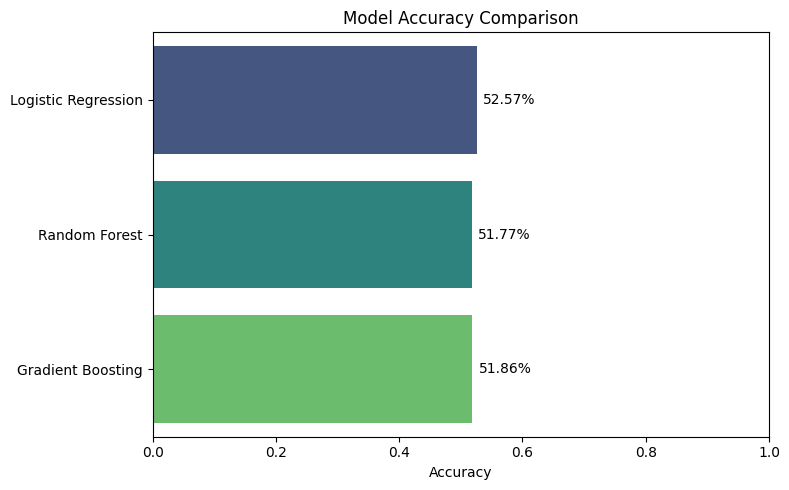

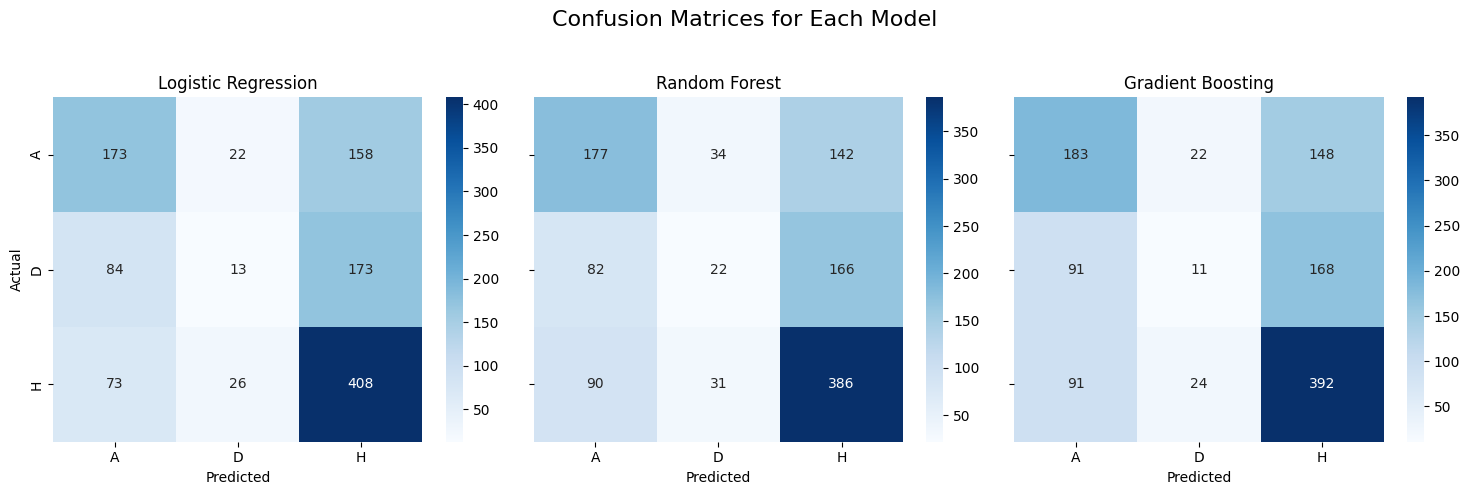


--- Classification Reports ---

Logistic Regression:
              precision    recall  f1-score   support

           A       0.52      0.49      0.51       353
           D       0.21      0.05      0.08       270
           H       0.55      0.80      0.65       507

    accuracy                           0.53      1130
   macro avg       0.43      0.45      0.41      1130
weighted avg       0.46      0.53      0.47      1130


Random Forest:
              precision    recall  f1-score   support

           A       0.51      0.50      0.50       353
           D       0.25      0.08      0.12       270
           H       0.56      0.76      0.64       507

    accuracy                           0.52      1130
   macro avg       0.44      0.45      0.42      1130
weighted avg       0.47      0.52      0.48      1130


Gradient Boosting:
              precision    recall  f1-score   support

           A       0.50      0.52      0.51       353
           D       0.19      0.04      

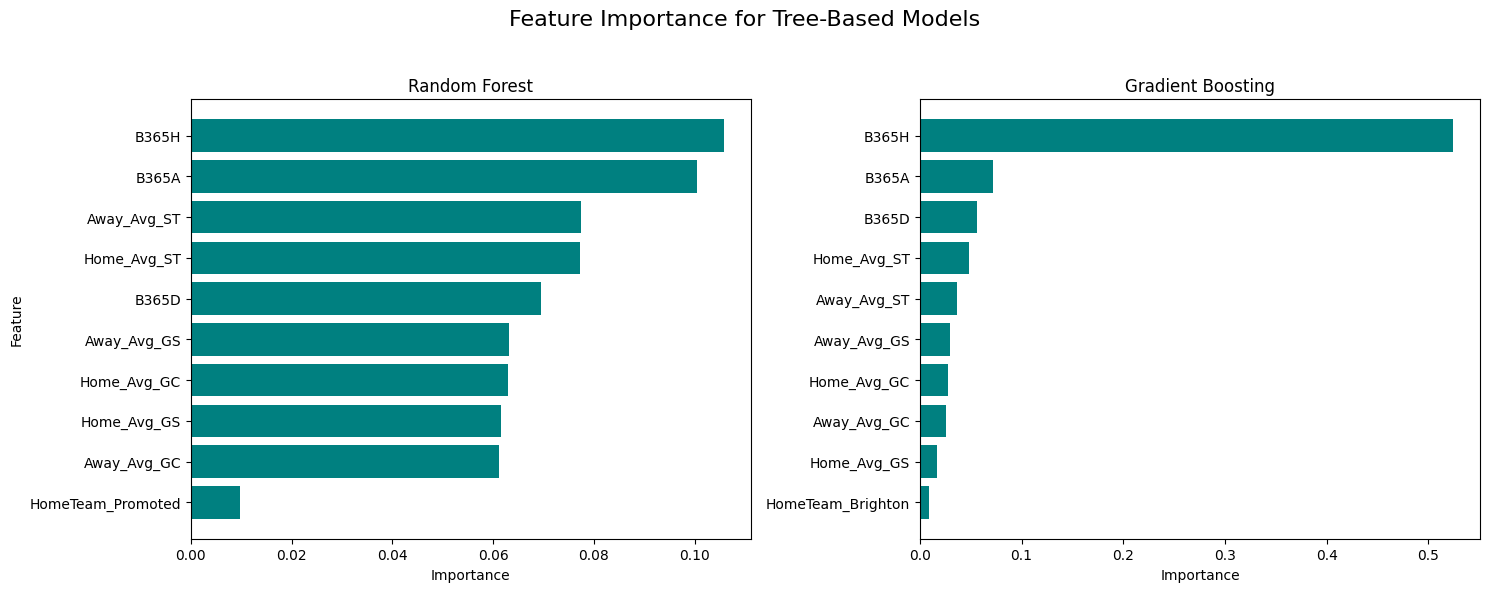

In [6]:
# libs for visualiasatiaon and classification
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 6.  Model Evaluation ---

# Store model names and predictions
models = {
    'Logistic Regression': lr_preds,
    'Random Forest': rf_preds,
    'Gradient Boosting': gb_preds
}
model_instances = {
    'Logistic Regression': log_reg,
    'Random Forest': rand_forest,
    'Gradient Boosting': grad_boost
}

# a) Accuracy Comparison Bar Plot
accuracies = {
    'Logistic Regression': accuracy_score(y_test, lr_preds),
    'Random Forest': accuracy_score(y_test, rf_preds),
    'Gradient Boosting': accuracy_score(y_test, gb_preds)
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracies.values()), y=list(accuracies.keys()), palette='viridis')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1)
for i, acc in enumerate(accuracies.values()):
    plt.text(acc + 0.01, i, f'{acc:.2%}', va='center')
plt.tight_layout()
plt.show()

# b) Confusion Matrix Heatmaps
labels = ['A', 'D', 'H']  # Away, Draw, Home
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Confusion Matrices for Each Model', fontsize=16)

for i, (name, preds) in enumerate(models.items()):
    cm = confusion_matrix(y_test, preds, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=labels, yticklabels=labels)
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual' if i == 0 else '')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# c) Classification Reports
print("\n--- Classification Reports ---")
for name, preds in models.items():
    print(f"\n{name}:")
    print(classification_report(y_test, preds, labels=labels))

# d) Feature Importance for Random Forest and Gradient Boosting
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Feature Importance for Tree-Based Models', fontsize=16)

for i, model_name in enumerate(['Random Forest', 'Gradient Boosting']):
    model = model_instances[model_name]
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features
    feature_names = X_train.columns[indices]
    ax = axes[i]
    ax.barh(feature_names, importances[indices], color='teal')
    ax.set_title(model_name)
    ax.set_xlabel('Importance')
    if i == 0:
        ax.set_ylabel('Feature')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

##Observation
Betting odds dominate, followed by recent form (shots on target, goals). Promoted team status is less relevant, possibly because its effect is captured by form or odds.

**Gradient Boosting** places extreme weight on B365H, suggesting it’s overfitting to home win odds. Other features contribute less compared to Random Forest.

### Some Insights after observing the results

**Betting Odds has mainly Dominate**: B365H, B365A, and B365D are the most important features across both models, reflecting that market predictions (aggregating expert and statistical data) are highly predictive. This aligns with sports analytics, where odds often outperform basic models.

**Our Feature Engineered Form Matters**: Shots on target (_Avg_ST) and goals scored/conceded (_Avg_GS, _Avg_GC) add value, especially in Random Forest, showing your engineered rolling averages are useful.

**Promoted Teams**: Low importance for HomeTeam_Promoted and specific teams (e.g., HomeTeam_Brighton) suggests team-specific or promotion effects are overshadowed by odds and form.


**Model Differences**: Gradient Boosting assigns much higher importance to B365H (0.5 vs. 0.1), indicating potential overfitting or sensitivity to this feature. Random Forest distributes importance more evenly.


______________________________________________________________________________

Gradient Boosting’s higher values (e.g., 0.5 for B365H) suggest it’s more focused on a single feature, while Random Forest balances across more features. Mostly as Homewins are common majority in football.  5649 matches may have a strong home win bias (common in football), amplifying B365H’s role in Gradient Boosting